In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

## global variables

In [2]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv'

time_step = 24
num_feats = 1
evaluation_results = []

# model specification
neurons = 250
epochs = 10
batch_size = 64

## helper functions

In [8]:
# Modified evaluate_model function to store results in evaluation_results



def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
#   save_path = os.path.join('./assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
#   plt.savefig(save_path)
#   print(f'plot saved to {save_path}')
  plt.show()
#   plt.close()

## Base BiLSTM

In [4]:
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

data = data[(data.index.month.isin([6, 7, 8])) & (data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences with time steps
# def create_dataset(dataset, time_step=1):
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# Set time_step (lookback window for BiLSTM)
time_step = 24  # Predict based on past 24 hours (1 day)
X, y = create_dataset(scaled_data, time_step)
print(f'X, y shape {X.shape} {y.shape}')
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_2642/1036345364.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


dataset shape (8832, 5)
X, y shape (8808, 24, 5) (8808,)


In [5]:
print("Training BiLSTM only...")
print("\n")

model = build_bilstm_model(time_step)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

y_train_predict = scaler.inverse_transform(
    np.concatenate([y_train_predict, X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_predict = scaler.inverse_transform(
    np.concatenate([y_test_predict, X_test[:, -1, 1:]], axis=1)
)[:, 0]

y_train_actual = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

evaluate_model(y_train_actual, y_train_predict, 'BiLSTM', 'Training')
evaluate_model(y_test_actual, y_test_predict, 'BiLSTM', 'Testing')

Training BiLSTM only...


Epoch 1/10
111/111 [==============================] - 33s 273ms/step - loss: 0.0135 - val_loss: 0.0071
Epoch 2/10
111/111 [==============================] - 31s 279ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 3/10
111/111 [==============================] - 31s 280ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 4/10
111/111 [==============================] - 27s 245ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 5/10
111/111 [==============================] - 21s 192ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 6/10
111/111 [==============================] - 14s 127ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 7/10
111/111 [==============================] - 15s 134ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 8/10
111/111 [==============================] - 14s 127ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 9/10
111/111 [==============================] - 15s 137ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 10/10
56/56 [============================

In [6]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,172.709510,99269.157901,315.070084,0.924643
1,BiLSTM,Testing,199.971976,120626.841583,347.313751,0.859553


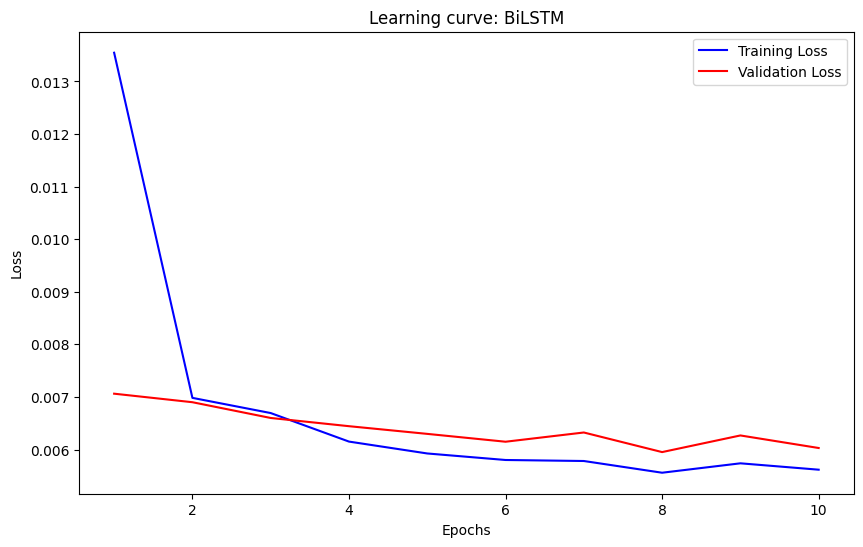

In [9]:
plot_learning_curve(history, 'BiLSTM')

## GBDT-BiLSTM

In [10]:
# Load and split data
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

data = data[(data.index.month.isin([6, 7, 8])) & (data.index.year == 2021)]

# data = data[(data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]

X = dataset.iloc[:, 1:].values  # Features
y = dataset.iloc[:, 0].values   # Target

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]




/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_2642/164482500.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


In [11]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_train)
gbdt_output_test = gbdt.predict(X_test)

In [12]:
# Evaluate model performance on training and test sets
evaluate_model(y_train, gbdt_output_train, 'GBDT', 'Training')
evaluate_model(y_test, gbdt_output_test, 'GBDT', 'Testing')

In [13]:


# Step 3: Scale the model outputs
scaler = MinMaxScaler()
gbdt_output_train_scaled = scaler.fit_transform(gbdt_output_train.reshape(-1, 1))
gbdt_output_test_scaled = scaler.transform(gbdt_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_gbdt, y_train_bilstm_gbdt = create_dataset(gbdt_output_train_scaled, time_step)
X_test_bilstm_gbdt, y_test_bilstm_gbdt = create_dataset(gbdt_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_gbdt = X_train_bilstm_gbdt.reshape(X_train_bilstm_gbdt.shape[0], time_step, 1)
X_test_bilstm_gbdt = X_test_bilstm_gbdt.reshape(X_test_bilstm_gbdt.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_gbdt = model.fit(X_train_bilstm_gbdt, y_train_bilstm_gbdt, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_gbdt, y_test_bilstm_gbdt), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_gbdt_scaled = model.predict(X_test_bilstm_gbdt)

y_pred_bilstm_gbdt = scaler.inverse_transform(y_pred_bilstm_gbdt_scaled)
y_test_bilstm_gbdt_actual_rescaled = scaler.inverse_transform(y_test_bilstm_gbdt.reshape(-1, 1))

evaluate_model(y_test_bilstm_gbdt_actual_rescaled, y_pred_bilstm_gbdt, 'BiLSTM (GBDT)', 'Testing')

dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/10
111/111 [==============================] - 15s 118ms/step - loss: 0.0136 - val_loss: 0.0032
Epoch 2/10
111/111 [==============================] - 15s 131ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 3/10
111/111 [==============================] - 14s 124ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 4/10
111/111 [==============================] - 16s 141ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 5/10
111/111 [==============================] - 15s 137ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 6/10
111/111 [==============================] - 14s 126ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 7/10
111/111 [==============================] - 14s 126ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/10
111/111 [==============================] - 15s 135ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 9/10
111/111 [==============================] - 14s 125ms/step - loss: 0.0037 - val_l

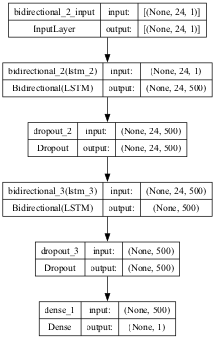

In [14]:
# Plotting the model architecture

plot_model(model, to_file='bilstm_gbdt.png', show_shapes=True, show_layer_names=True, dpi=50)


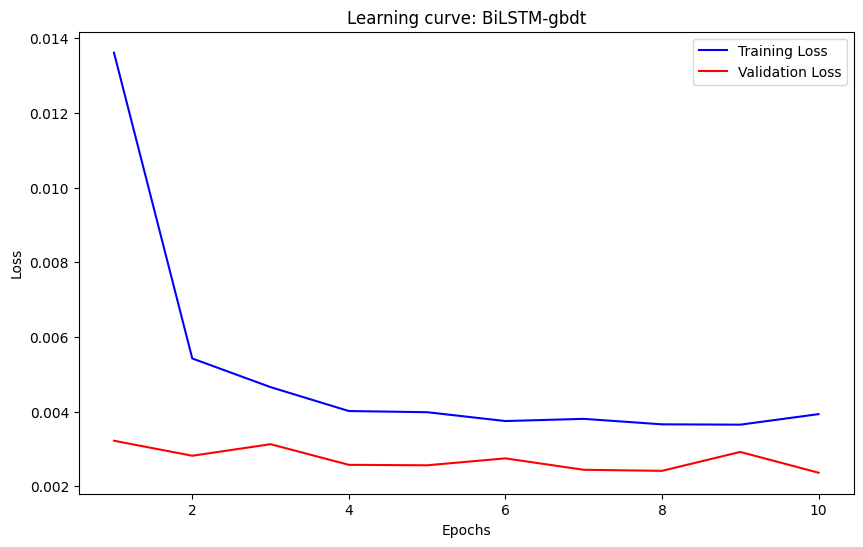

In [15]:
plot_learning_curve(history_gbdt, 'BiLSTM-gbdt')

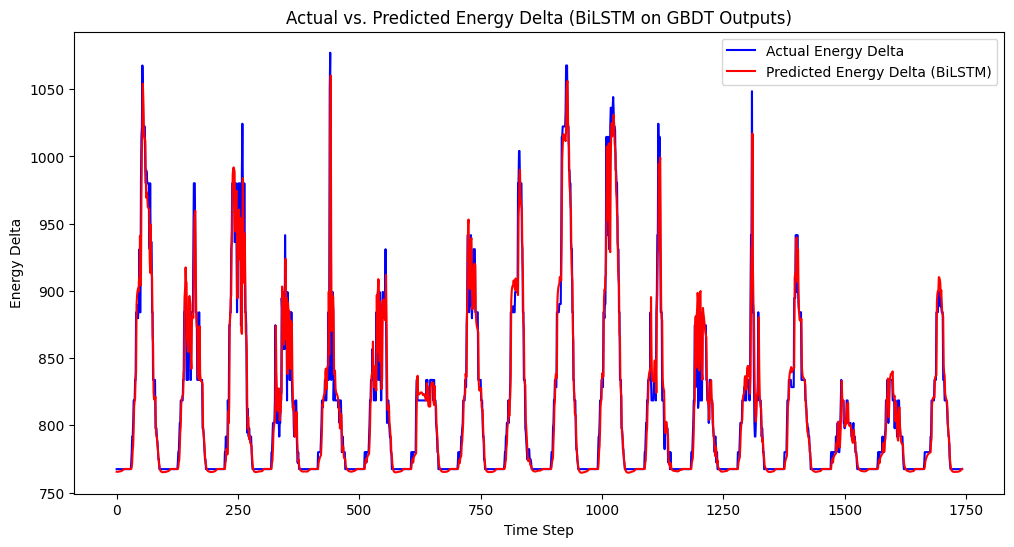

In [16]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_gbdt_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_gbdt, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on GBDT Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [17]:

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data

xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
xgb_output_train = xgb.predict(X_train)
xgb_output_test = xgb.predict(X_test)

evaluate_model(y_train, xgb_output_train, 'XGB', 'Training')
evaluate_model(y_test, xgb_output_test, 'XGB', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

xgb_output_train_scaled = scaler.fit_transform(xgb_output_train.reshape(-1, 1))
xgb_output_test_scaled = scaler.transform(xgb_output_test.reshape(-1, 1))


# Create BiLSTM input for all three model outputs

X_train_bilstm_xgb, y_train_bilstm_xgb = create_dataset(xgb_output_train_scaled, time_step)
X_test_bilstm_xgb, y_test_bilstm_xgb = create_dataset(xgb_output_test_scaled, time_step)

X_train_bilstm_xgb = X_train_bilstm_xgb.reshape(X_train_bilstm_xgb.shape[0], time_step, 1)
X_test_bilstm_xgb = X_test_bilstm_xgb.reshape(X_test_bilstm_xgb.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs

print("Training BiLSTM on XGB outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_xgb = model.fit(X_train_bilstm_xgb, y_train_bilstm_xgb, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_xgb, y_test_bilstm_xgb), verbose=1)

# Step 7: Predict with BiLSTM

y_pred_bilstm_xgb_scaled = model.predict(X_test_bilstm_xgb)
y_pred_bilstm_xgb = scaler.inverse_transform(y_pred_bilstm_xgb_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_xgb_actual_rescaled = scaler.inverse_transform(y_test_bilstm_xgb.reshape(-1, 1))

evaluate_model(y_test_bilstm_xgb_actual_rescaled, y_pred_bilstm_xgb, 'BiLSTM (XGB)', 'Testing')

dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on XGB outputs...


Epoch 1/10
111/111 [==============================] - 14s 113ms/step - loss: 0.0150 - val_loss: 0.0042
Epoch 2/10
111/111 [==============================] - 17s 154ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 3/10
111/111 [==============================] - 15s 131ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 4/10
111/111 [==============================] - 14s 130ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 5/10
111/111 [==============================] - 14s 127ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 6/10
111/111 [==============================] - 15s 136ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 7/10
111/111 [==============================] - 15s 135ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 8/10
111/111 [==============================] - 15s 136ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 9/10
111/111 [==============================] - 15s 131ms/step - loss: 0.0041 - val_lo

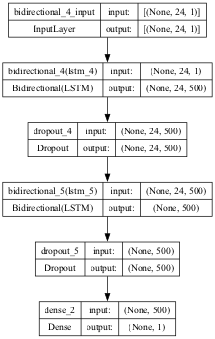

In [18]:
# Plotting the model architecture
plot_model(model, to_file='bilstm_xgb.png', show_shapes=True, show_layer_names=True, dpi=50)

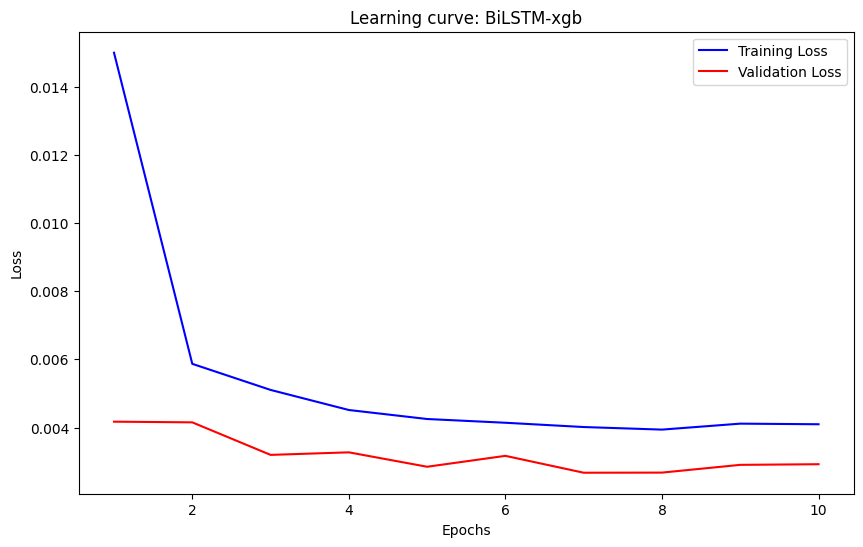

In [19]:
plot_learning_curve(history_xgb, 'BiLSTM-xgb')

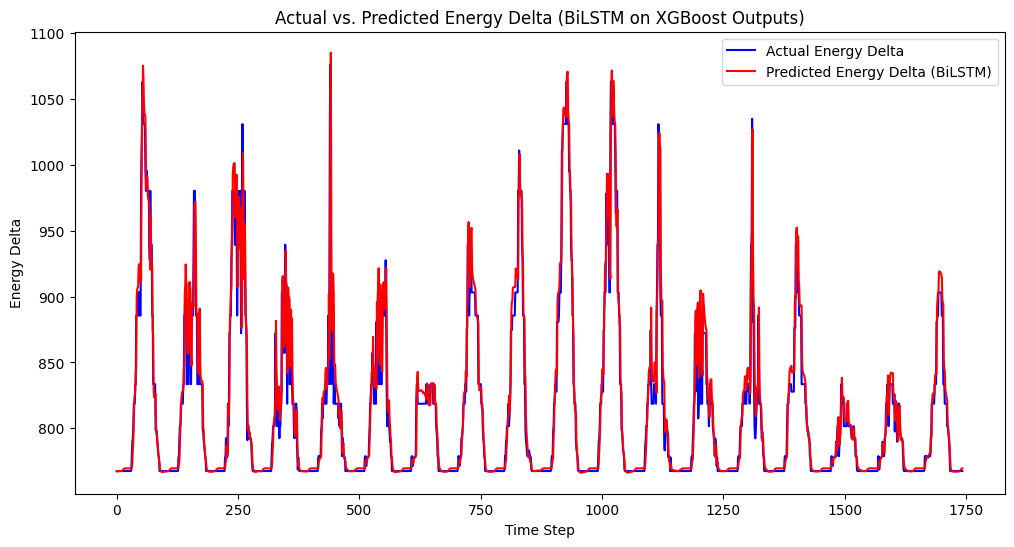

In [20]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_xgb_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_xgb, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on XGBoost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [21]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5)

catboost.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
catboost_output_train = catboost.predict(X_train)
catboost_output_test = catboost.predict(X_test)

# Evaluate model performance on training and test sets 
evaluate_model(y_train, catboost_output_train, 'Catboost', 'Training')
evaluate_model(y_test, catboost_output_test, 'Catboost', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

catboost_output_train_scaled = scaler.fit_transform(catboost_output_train.reshape(-1, 1))
catboost_output_test_scaled = scaler.transform(catboost_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_catboost, y_train_bilstm_catboost = create_dataset(catboost_output_train_scaled, time_step)
X_test_bilstm_catboost, y_test_bilstm_catboost = create_dataset(catboost_output_test_scaled, time_step)

X_train_bilstm_catboost = X_train_bilstm_catboost.reshape(X_train_bilstm_catboost.shape[0], time_step, 1)
X_test_bilstm_catboost = X_test_bilstm_catboost.reshape(X_test_bilstm_catboost.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on CatBoost outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_catboost = model.fit(X_train_bilstm_catboost, y_train_bilstm_catboost, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_catboost, y_test_bilstm_catboost), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_catboost_scaled = model.predict(X_test_bilstm_catboost)
y_pred_bilstm_catboost = scaler.inverse_transform(y_pred_bilstm_catboost_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_catboost_actual_rescaled = scaler.inverse_transform(y_test_bilstm_catboost.reshape(-1, 1))

evaluate_model(y_test_bilstm_catboost_actual_rescaled, y_pred_bilstm_catboost, 'BiLSTM (CatBoost)', 'Testing')

0:	learn: 1145.9580703	total: 59.2ms	remaining: 5.86s
1:	learn: 1144.9687345	total: 59.8ms	remaining: 2.93s
2:	learn: 1143.9989487	total: 60.4ms	remaining: 1.95s
3:	learn: 1143.0253386	total: 61.1ms	remaining: 1.47s
4:	learn: 1142.0707623	total: 61.6ms	remaining: 1.17s
5:	learn: 1141.0922685	total: 62.3ms	remaining: 975ms
6:	learn: 1140.1302831	total: 62.9ms	remaining: 835ms
7:	learn: 1139.1654891	total: 63.4ms	remaining: 729ms
8:	learn: 1138.2048507	total: 64ms	remaining: 647ms
9:	learn: 1137.2557434	total: 64.7ms	remaining: 582ms
10:	learn: 1136.2980935	total: 65.2ms	remaining: 528ms
11:	learn: 1135.3392834	total: 65.8ms	remaining: 483ms
12:	learn: 1134.3737120	total: 66.4ms	remaining: 444ms
13:	learn: 1133.4111418	total: 67ms	remaining: 412ms
14:	learn: 1132.4823494	total: 67.5ms	remaining: 383ms
15:	learn: 1131.5442305	total: 68ms	remaining: 357ms
16:	learn: 1130.5800100	total: 68.6ms	remaining: 335ms
17:	learn: 1129.6278229	total: 69.1ms	remaining: 315ms
18:	learn: 1128.6618448	to

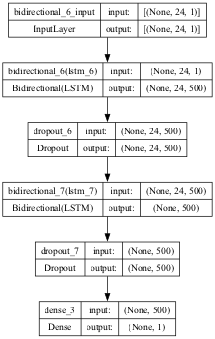

In [22]:
plot_model(model, to_file='bilstm_catboost.png', show_shapes=True, show_layer_names=True, dpi=50)


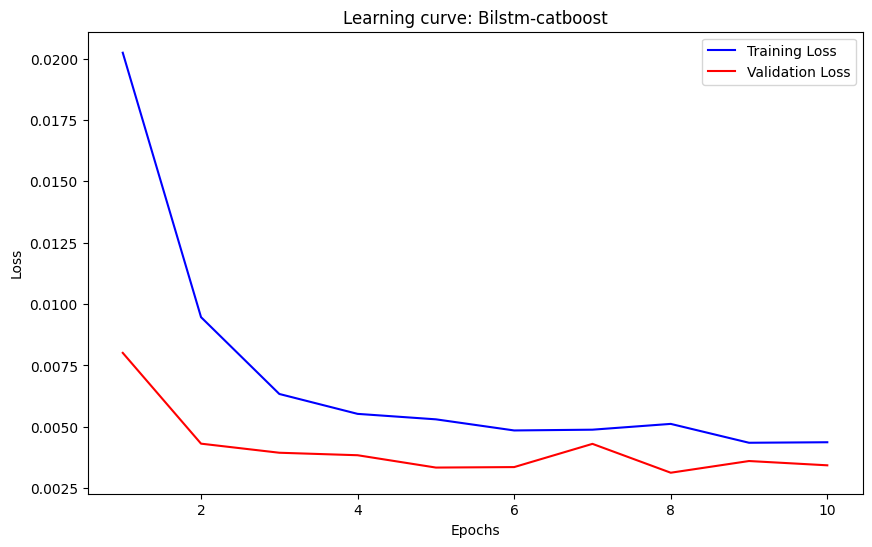

In [23]:
plot_learning_curve(history_catboost, 'Bilstm-catboost')

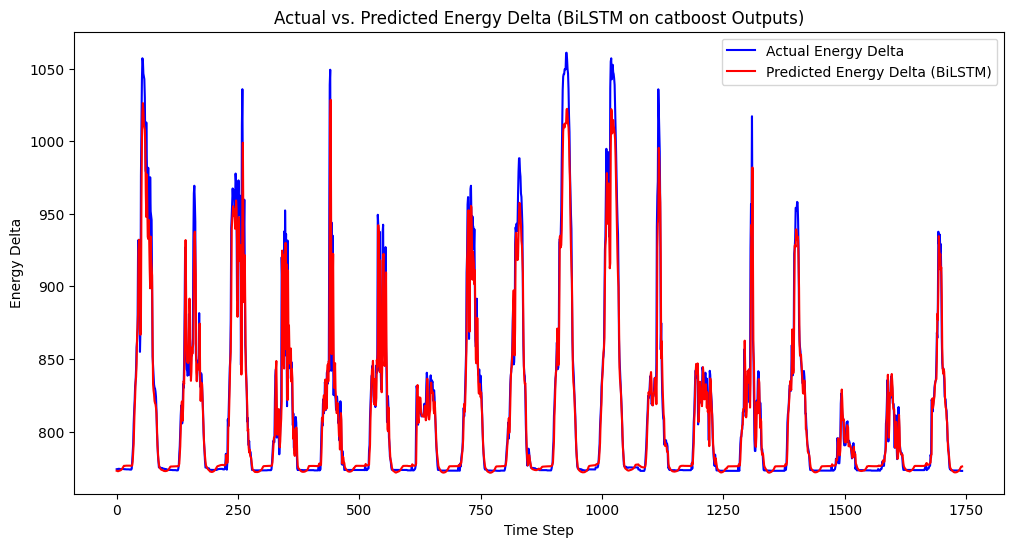

In [24]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_catboost_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_catboost, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on catboost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [25]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

lgbm.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
lgbm_output_train = lgbm.predict(X_train)
lgbm_output_test = lgbm.predict(X_test)


# Evaluate model performance on training and test sets
evaluate_model(y_train, lgbm_output_train, 'LightGBM', 'Training')
evaluate_model(y_test, lgbm_output_test, 'LightGBM', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()
lgbm_output_train_scaled = scaler.fit_transform(lgbm_output_train.reshape(-1, 1))
lgbm_output_test_scaled = scaler.transform(lgbm_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_lgbm, y_train_bilstm_lgbm = create_dataset(lgbm_output_train_scaled, time_step)
X_test_bilstm_lgbm, y_test_bilstm_lgbm = create_dataset(lgbm_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_lgbm = X_train_bilstm_lgbm.reshape(X_train_bilstm_lgbm.shape[0], time_step, 1)
X_test_bilstm_lgbm = X_test_bilstm_lgbm.reshape(X_test_bilstm_lgbm.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_lgbm = model.fit(X_train_bilstm_lgbm, y_train_bilstm_lgbm, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_lgbm, y_test_bilstm_lgbm), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_lgbm_scaled = model.predict(X_test_bilstm_lgbm)
y_pred_bilstm_lgbm = scaler.inverse_transform(y_pred_bilstm_lgbm_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_lgbm_actual_rescaled = scaler.inverse_transform(y_test_bilstm_lgbm.reshape(-1, 1))
evaluate_model(y_test_bilstm_lgbm_actual_rescaled, y_pred_bilstm_lgbm, 'BiLSTM (LightGBM)', 'Testing')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 7065, number of used features: 4
[LightGBM] [Info] Start training from score 848.107714
dataset shape (7065, 1)
dataset shape (1767, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/10
111/111 [==============================] - 14s 110ms/step - loss: 0.0132 - val_loss: 0.0055
Epoch 2/10
111/111 [==============================] - 12s 109ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 3/10
111/111 [==============================] - 14s 128ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 4/10
111/111 [==============================] - 13s 117ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/10
111/111 [==============================] - 14s 122ms/step - loss: 0.0045 - val_loss: 0.

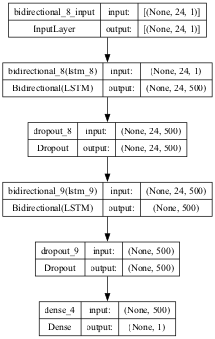

In [26]:
plot_model(model, to_file='bilstm_lightgbm.png', show_shapes=True, show_layer_names=True, dpi=50)

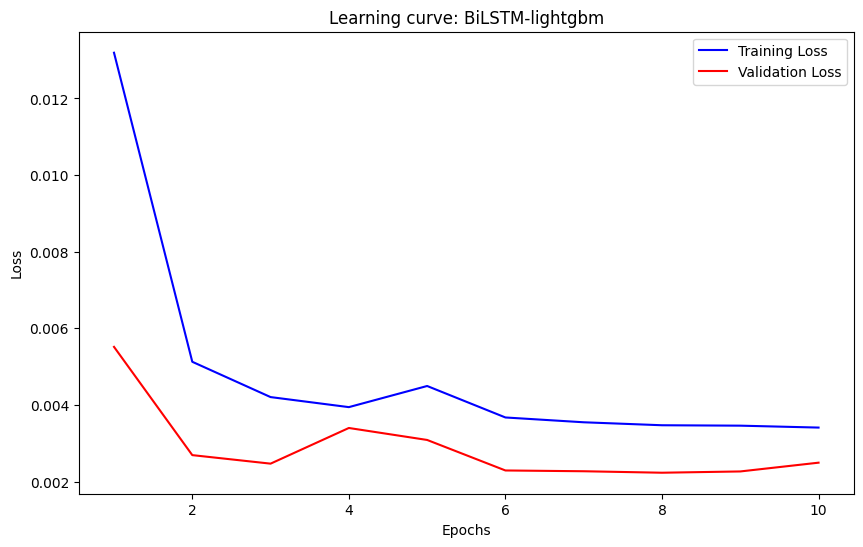

In [27]:
plot_learning_curve(history_lgbm, 'BiLSTM-lightgbm')

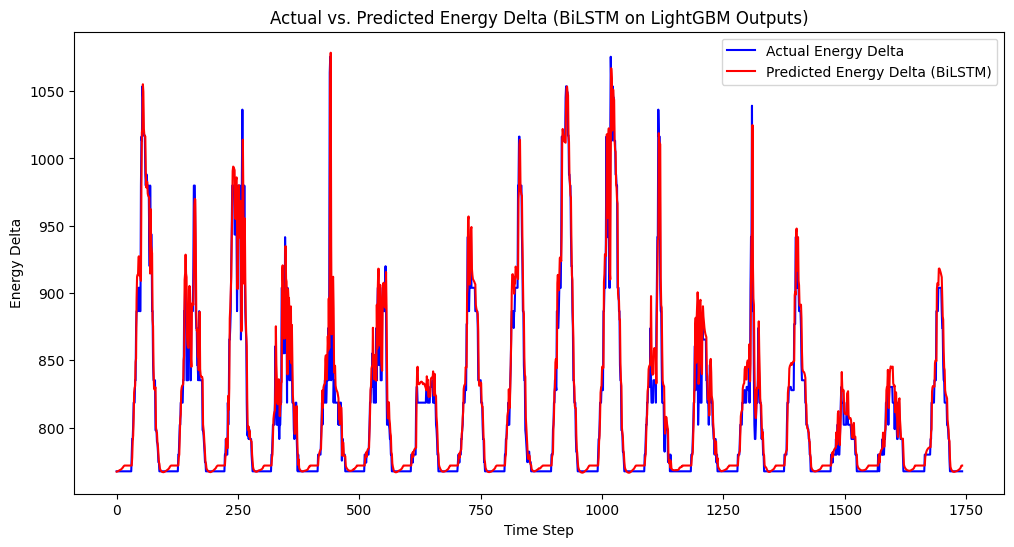

In [28]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_lgbm_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_lgbm, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on LightGBM Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [29]:
results_df = pd.DataFrame(evaluation_results)
print("\nevaluation metrics table: ")


evaluation metrics table: 


In [30]:
results_df

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,172.709510,9.926916e+04,315.070084,0.924643
1,BiLSTM,Testing,199.971976,1.206268e+05,347.313751,0.859553
2,GBDT,Training,850.222922,1.101081e+06,1049.324191,0.162946
3,GBDT,Testing,749.790404,8.033409e+05,896.292856,0.062563
4,BiLSTM (GBDT),Testing,9.005355,3.146102e+02,17.737255,0.921396
5,XGB,Training,850.609477,1.102446e+06,1049.974468,0.161908
6,XGB,Testing,749.741968,8.029134e+05,896.054378,0.063062
7,BiLSTM (XGB),Testing,9.471886,3.334685e+02,18.261120,0.916997
8,Catboost,Training,853.869472,1.112913e+06,1054.946758,0.153952
9,Catboost,Testing,750.534126,8.022883e+05,895.705454,0.063792


In [31]:
from tensorflow.keras import backend as K
K.clear_session()
